In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import basename, dirname
from shutil import copyfile

import json
import pickle
from collections import OrderedDict

import torch

In [3]:
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
import numpy as np

In [5]:
os.chdir("..")

In [6]:
from da.clust_utils import cramers_corrected_stat, flatten_dict

In [7]:
np.random.seed(21)

In [22]:
def plot_conf_matrix(exp, langpair, clustering_level):
    if exp == 'nmt':
        model_name = 'concat60'
    elif exp == 'bert':
        model_name = 'xlm-roberta-base'
    
    src_lang, tgt_lang = langpair.split('-') 

    labels = {}
    
    if clustering_level == 'sent':
        loaddir = f"experiments/{src_lang}_{tgt_lang}_{model_name}/{exp}-clusters-sent"
    elif clustering_level == 'doc':
        loaddir = f"experiments/{src_lang}_{tgt_lang}_{model_name}/{exp}-clusters-doc"        
    
    domain_names = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
    for split in ['train', 'dev-cl', 'test-cl']:
        print(f"{split}\n###")
        for domain_name in domain_names:
            if clustering_level == 'sent':
                fn = f"{loaddir}/{domain_name}.{split}.clust.{exp}.sent" 
            elif clustering_level == 'doc':
                fn = f"{loaddir}/{domain_name}.{split}.clust.{exp}.doc" 
                
            with open(fn) as f:
                labels[domain_name] = [int(l.strip()) for l in f.readlines()]

        labels_hat = []
        labels_true = []
        for k,v in labels.items():
            labels_hat.extend(v)
            labels_true.extend([k] * len(v))


        conf_matrix = pd.crosstab(np.array(labels_true), np.array(labels_hat))
        corr_k = cramers_corrected_stat(conf_matrix)
        print("K =", corr_k)
        print(conf_matrix)

    #     print()
    #     print(conf_matrix.sum(axis=0))

        sns.heatmap(conf_matrix,
                    cmap="YlGnBu", annot=True, cbar=False)

        plt.show()

# NMT sent clusters

train
###
K = 0.6296853679817018
col_0               0       1       2       3
row_0                                        
EMEA            30855  109132  355746    4337
Europarl       431546    3127   10673   55351
JRC-Acquis     261620   81295  154571    2721
OpenSubtitles   24766   36720    8429  431595


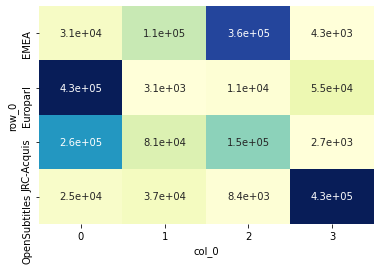

dev-cl
###
K = 0.6581642678586537
col_0             0    1     2     3
row_0                               
EMEA            536  295  2542    33
Europarl       3201    1    41   323
JRC-Acquis     2275  126   694    11
OpenSubtitles   126   99    48  4033


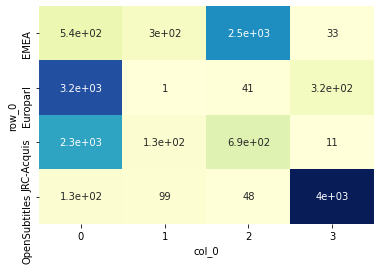

test-cl
###
K = 0.6640465417761539
col_0             0    1     2     3
row_0                               
EMEA            318  449  5066    75
Europarl       2817    3    77   368
JRC-Acquis     2187   79   725    17
OpenSubtitles   206  129    42  2686


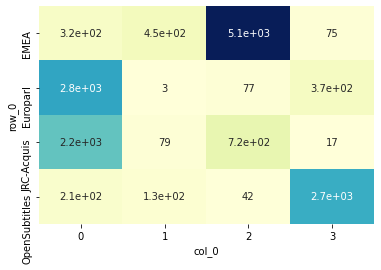

In [23]:
plot_conf_matrix('nmt', 'de-en', 'sent')

# NMT doc clusters

train
###
K = 0.9895340194800907
col_0               0       1       2       3
row_0                                        
EMEA                0      59  495374    4637
Europarl           25  500491      11     170
JRC-Acquis          0    8802    1595  489810
OpenSubtitles  500968     542       0       0


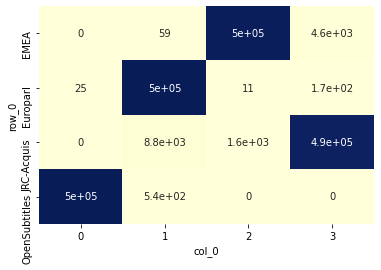

dev-cl
###
K = 0.9676378641033098
col_0             0     1     2     3
row_0                                
EMEA              0     0  3406     0
Europarl          0  3566     0     0
JRC-Acquis        0   348     0  2758
OpenSubtitles  4306     0     0     0


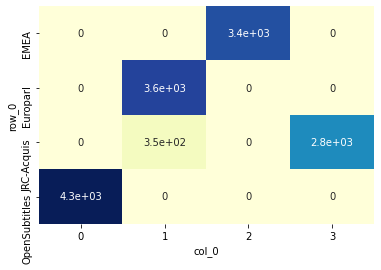

test-cl
###
K = 0.9964107112831756
col_0             0     1     2     3
row_0                                
EMEA              0     0  5908     0
Europarl          0  3265     0     0
JRC-Acquis        0    34     0  2974
OpenSubtitles  3063     0     0     0


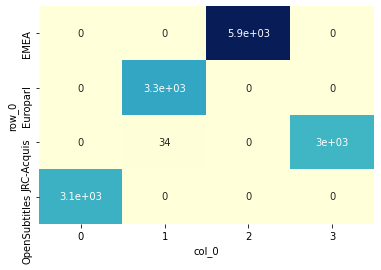

In [24]:
plot_conf_matrix('nmt', 'de-en', 'doc')

# BERT sent clusters

In [25]:
plot_conf_matrix('bert', 'en-et', 'sent')

train
###


FileNotFoundError: [Errno 2] No such file or directory: 'experiments/en_et_xlm-roberta-base/bert-clusters-sent/Europarl.train.clust.bert.sent'

# BERT doc clusters

In [26]:
plot_conf_matrix('bert', 'en-et', 'doc')

train
###


FileNotFoundError: [Errno 2] No such file or directory: 'experiments/en_et_xlm-roberta-base/bert-clusters-doc/Europarl.train.clust.bert.doc'

# Bert layer 11 sent clusters

In [11]:
model_name = 'xlm-roberta-base'

Corr k: 0.36107611320457045
col_0               0      1       2       3
row_0                                       
EMEA           164064  28303  123955   94218
Europarl       135936    879  336682   26669
JRC-Acquis     117046  70862  278139   33973
OpenSubtitles  184534  45496    8221  262625


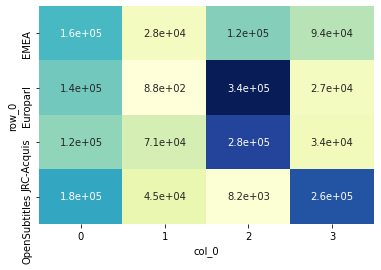

Corr k: 0.36929188429688964
col_0             0    1     2     3
row_0                               
EMEA           1431  106  1350   461
Europarl        939    2  2656   119
JRC-Acquis      621   43  2151   190
OpenSubtitles  1330   81    57  1576


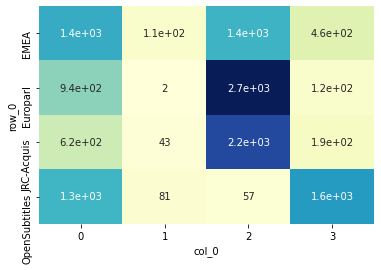

Corr k: 0.3716364232821842
col_0             0   1     2     3
row_0                              
EMEA           1423  96  1457   339
Europarl        888   1  2096   122
JRC-Acquis      604  25  2431   130
OpenSubtitles  1412  80    91  1502


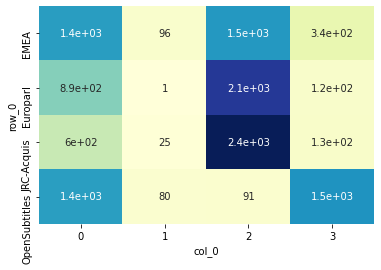

In [12]:
import matplotlib.pyplot as plt

with open(f"experiments/{src_lang}_{tgt_lang}_{model_name}/internals-docs/kmeans_train_sent.pkl", 'rb') as f:
    kmeans = pickle.load(f)
    
savedir = f"experiments/{src_lang}_{tgt_lang}_{model_name}/nmt-clusters-sent"
if not os.path.isdir(savedir):
    os.mkdir(savedir)

for split in ['train', 'dev-cl', 'test-cl']:
    fn = f"experiments/{src_lang}_{tgt_lang}_{model_name}/internals-docs/sent_means_{split}.pkl"
    with open(fn, 'rb') as f:
        data_encoded = pickle.load(f)
    
    labels_hat, labels_true = kmeans_predict(kmeans, data_encoded, split=='train')
    
    conf_matrix = pd.crosstab(labels_true, labels_hat)
    corr_k = cramers_corrected_stat(conf_matrix)

    print(f"Corr k: {corr_k}")
    print(conf_matrix)
    
    i = 0
    for domain_name, v in data_encoded.items():
        fn = f"{domain_name}.{split}.clust.nmt.sent"
        np.savetxt(f"{savedir}/{fn}", labels_hat[i:i+len(v)].astype(int), fmt="%i")
        i += len(v)

    sns.heatmap(conf_matrix,
                cmap="YlGnBu", annot=True, cbar=False)
    plt.show()

# BERT layer 11 doc clusters

In [ ]:
import matplotlib.pyplot as plt

with open(f"experiments/{src_lang}_{tgt_lang}_{model_name}/internals-docs/kmeans_train_doc.pkl", 'rb') as f:
    kmeans = pickle.load(f)
    
savedir = f"experiments/{src_lang}_{tgt_lang}_{model_name}/nmt-clusters-doc"
if not os.path.isdir(savedir):
    os.mkdir(savedir)

for split in ['train', 'dev-cl', 'test-cl']:
    print(split)
    print("###")
    fn = f"experiments/{src_lang}_{tgt_lang}_{model_name}/internals-docs/doc_encoded_{split}.pkl"
    with open(fn, 'rb') as f:
        data_encoded = pickle.load(f)
    
    labels_hat, labels_true = kmeans_predict(kmeans, data_encoded, split=='train')
    
    conf_matrix = pd.crosstab(labels_true, labels_hat)
    corr_k = cramers_corrected_stat(conf_matrix)

    print(f"Corr k: {corr_k}")
    print(conf_matrix)
    
    i = 0
    for domain_name, v in data_encoded.items():
        fn = f"{domain_name}.{split}.clust.nmt.doc"
        np.savetxt(f"{savedir}/{fn}", labels_hat[i:i+len(v)].astype(int), fmt="%i")
        i += len(v)

    sns.heatmap(conf_matrix,
                cmap="YlGnBu", annot=True, cbar=False)
    plt.show()
    print()

# Bert layer 7 sent clusters

0.24168047830449288
col_0               0       1      2       3
row_0                                       
EMEA            72707  140991  39598  157244
Europarl       166334  177192  56586  100054
JRC-Acquis     162534  163134  29920  144432
OpenSubtitles   46245   50394  84391  319846

col_0
0    447820
1    531711
2    210495
3    721576
dtype: int64


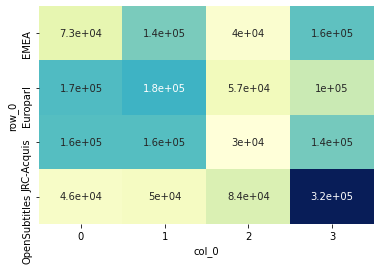

0.2548759115018526
col_0             0     1    2     3
row_0                               
EMEA            777  1258  188  1125
Europarl       1342  1277  371   726
JRC-Acquis     1279   689  185   852
OpenSubtitles   194   398  534  1918

col_0
0    3592
1    3622
2    1278
3    4621
dtype: int64


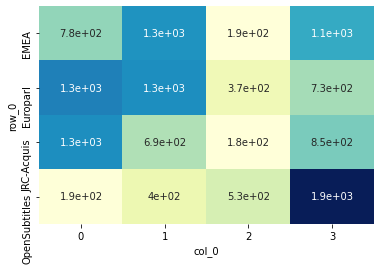

0.24212417442137057
col_0             0     1    2     3
row_0                               
EMEA            891  1134  179  1111
Europarl        967  1209  341   590
JRC-Acquis     1452   730  199   809
OpenSubtitles   351   393  447  1894

col_0
0    3661
1    3466
2    1166
3    4404
dtype: int64


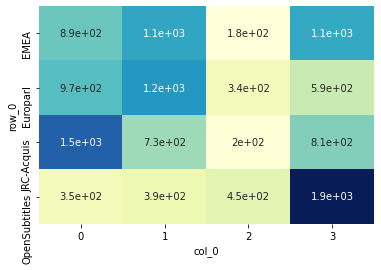

In [14]:
labels_bert = {}
domain_names = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
for split in ['train', 'dev-cl', 'test-cl']:

    for domain_name in domain_names:
        fn = f"experiments/data-clust/clusters/cl-{domain_name}.en-et.docs.{split}.clusters_sent_4.txt" # TODO: change to train
        with open(fn) as f:
            labels_bert[domain_name] = [int(l[:-1]) for l in f.readlines()]


    labels_bert_all = []
    labels_bert_all_true = []
    for k,v in labels_bert.items():
        labels_bert_all.extend(v)
        labels_bert_all_true.extend([k] * len(v))



    conf_matrix = pd.crosstab(np.array(labels_bert_all_true), np.array(labels_bert_all))
    corr_k = cramers_corrected_stat(conf_matrix)
    print(corr_k)
    print(conf_matrix)

    print()
    print(conf_matrix.sum(axis=0))
    
    sns.heatmap(conf_matrix,
                cmap="YlGnBu", annot=True, cbar=False)

    plt.show()

# Bert 7 doc clusters

0.8089680719230101
col_0               0       1       2       3
row_0                                        
EMEA            42870  344373    3200   20097
Europarl          521    3372  493821    2452
JRC-Acquis     279334  152902   61959    5825
OpenSubtitles    1001    9881     899  489095



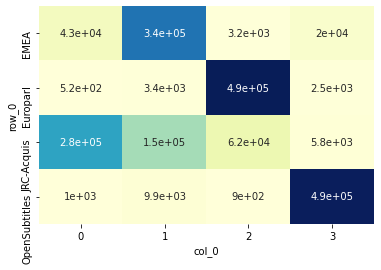

0.7643559453123278
col_0             0     1     2     3
row_0                                
EMEA           1616  1592   120    20
Europarl          0     0  3716     0
JRC-Acquis     1506   168  1326     5
OpenSubtitles     0     0     0  3044



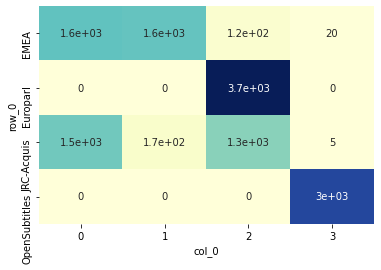

0.780887189413313
col_0            0     1     2     3
row_0                               
EMEA           683  2532    46    54
Europarl        11     9  3066    21
JRC-Acquis     924    58  2208     0
OpenSubtitles    0     0     0  3085



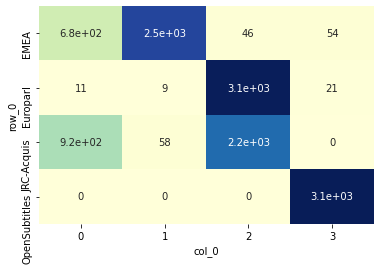

In [15]:
labels_bert = {}
domain_names = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]

for split in ['train', 'dev-cl', 'test-cl']:

    for domain_name in domain_names:
        fn = f"experiments/data-clust/clusters/cl-{domain_name}.en-et.docs.{split}.clusters_doc_4.txt" # TODO: change to train
        with open(fn) as f:
            labels_bert[domain_name] = [int(l[:-1]) for l in f.readlines()]


    labels_bert_all = []
    labels_bert_all_true = []
    for k,v in labels_bert.items():
        labels_bert_all.extend(v)
        labels_bert_all_true.extend([k] * len(v))



    conf_matrix = pd.crosstab(np.array(labels_bert_all_true), np.array(labels_bert_all))
    corr_k = cramers_corrected_stat(conf_matrix)
    print(corr_k)
    print(conf_matrix)


    sns.heatmap(conf_matrix,
                cmap="YlGnBu", annot=True, cbar=False)
    
    print()
    #print(conf_matrix.sum(axis=0))
    
    plt.show()

# Rand clusters

0.0
col_0               0       1       2       3
row_0                                        
EMEA           102629  103184  102148  102579
Europarl       124871  125306  125292  124697
JRC-Acquis     125152  125205  124859  124804
OpenSubtitles  125292  124911  125181  125492


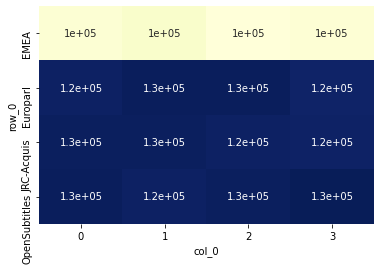

In [16]:
from random import sample

labels_rand = {}
domain_names = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
for domain_name in domain_names:
    fn = f"experiments/data-clust-new/clusters/cl-{domain_name}.en-et.docs.train.clusters_doc_4.txt" # TODO: change to train
    with open(fn) as f:
        labels_rand[domain_name] = [sample([0,1,2,3], 1)[0] for l in f.readlines()]
        
        
labels_rand_all = []
labels_rand_all_true = []
for k,v in labels_rand.items():
    labels_rand_all.extend(v)
    labels_rand_all_true.extend([k] * len(v))
    
    
conf_matrix = pd.crosstab(np.array(labels_rand_all_true), np.array(labels_rand_all))
corr_k = cramers_corrected_stat(conf_matrix)
print(corr_k)
print(conf_matrix)


sns.heatmap(conf_matrix,
            cmap="YlGnBu", annot=True, cbar=False)

plt.show()